In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from experiment_configs.test_config import test_config
config = test_config

In [4]:
from torch.utils.data import ConcatDataset

from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

from project_config import is_training, is_validation

from utils.visualizing import visualize_dataset, Visualizer


all_observations = observation_factory(gcp_client)
training_scenes = []
validation_scenes = []

for observation in all_observations:
    is_train = is_training(observation.name)
    is_val = is_validation(observation.name)

    assert not (is_train and is_val), "An observation cannot be in both training and validation"

    scene = observation_to_scene(config, observation)    
    if is_train:
        training_scenes.append(scene)
    elif is_val:
        validation_scenes.append(scene)
    else:
        print(f"Ignoring observation {observation.name}")


#all_scenes = training_scenes + validation_scenes
#for scene in all_scenes:
#    warn_if_nan_in_raw_raster(scene.raster_source)

training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes #random window sampling happens here
]
validation_datasets = [
    scene_to_validation_ds(config, scene) for scene in validation_scenes
]

train_dataset_merged = ConcatDataset(training_datasets)
# val_dataset_merged = ConcatDataset(validation_datasets)


2023-11-07 10:40:35:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2.tif to /tmp/tmpqdb4jj8v/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2.tif...
2023-11-07 10:40:36:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s1/Godavari_EastGodavari_81-84_16-66_2022-06-01_s1.tif to /tmp/tmpqdb4jj8v/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s1/Godavari_EastGodavari_81-84_16-66_2022-06-01_s1.tif...
2023-11-07 10:40:38:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/annotati

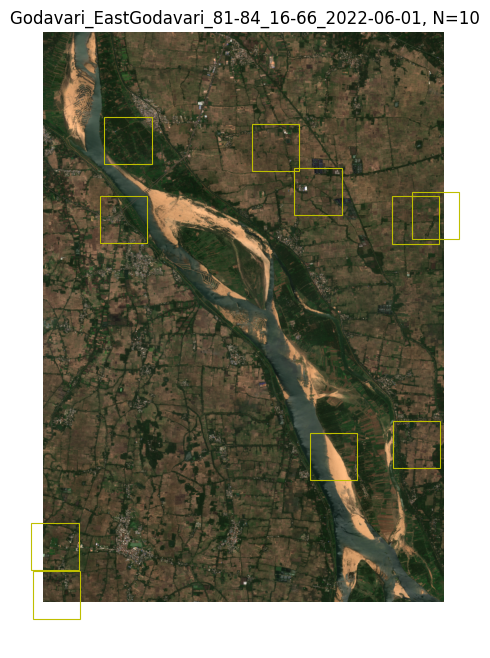

In [5]:
visualizer = Visualizer(config.s2_channels)
visualize_dataset(training_datasets, visualizer)

In [6]:
from os.path import expanduser

from models.model_factory import model_factory
from ml.optimizer_factory import optimizer_factory
from ml.learner import BinarySegmentationLearner

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

optimizer = optimizer_factory(config, model)

learner = BinarySegmentationLearner(
    config=config,
    model=model,
    optimizer=optimizer,
    train_ds=training_datasets[0],  # for development and debugging, use training_datasets[0] or similar to speed up
    valid_ds=training_datasets[0],  # for development and debugging, use training_datasets[1] or similar to speed up
    output_dir=expanduser("~/sandmining-watch/out/OUTPUT_DIR"),
)

learner.log_data_stats()

2023-11-07 10:40:46:rastervision: INFO - Loading weights from /home/gautam/sandmining-watch/out/OUTPUT_DIR/last-model.pth
2023-11-07 10:40:46:rastervision: INFO - train_ds: 10 items
2023-11-07 10:40:46:rastervision: INFO - valid_ds: 10 items


In [7]:
learner.train(epochs=1)

2023-11-07 10:40:46:rastervision: INFO - epoch: 0


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-07 10:40:50:rastervision: INFO - metrics:
{'avg_f1': 0.9998382925987244,
 'avg_precision': 1.0,
 'avg_recall': 0.999676525592804,
 'epoch': 0,
 'other_f1': 0.9998382925987244,
 'other_precision': 1.0,
 'other_recall': 0.999676525592804,
 'sandmine_average_precision': tensor(nan, device='cuda:0'),
 'sandmine_f1': 0.0,
 'sandmine_precision': 0.0,
 'sandmine_recall': 0.0,
 'train_bce_loss': 0.062481606006622316,
 'train_dice_loss': 0.09801712036132812,
 'train_time': datetime.timedelta(seconds=2, microseconds=612791),
 'val_bce_loss': tensor(0.0624, device='cuda:0'),
 'val_dice_loss': tensor(0.1000, device='cuda:0'),
 'valid_time': datetime.timedelta(seconds=1, microseconds=210236)}
